In [1]:
# Set the real field to be used to approximate numbers
prec = 60
RR = RealField(prec)

# Numerically get the parameter in the spectral curve not set by symmetry. 
# This is required to be accurate such that the ES constraints can be satisfied
a_RR = RR(gamma(1/6)^3 * gamma(1/3)^3 / 48 / sqrt(3) / pi^(3/2))
a_RR

7.1625084514764982

In [2]:
# Approximate now a_RR using rationals
den = 8
r = a_RR/den

# Copied from https://www.johndcook.com/blog/2010/10/20/best-rational-approximation/
def farey(x, N):
    a, b = 0, 1
    c, d = 1, 1
    while (b <= N and d <= N):
        mediant = float(a+c)/(b+d)
        if x == mediant:
            if b + d <= N:
                return a+c, b+d
            elif d > b:
                return c, d
            else:
                return a, b
        elif x > mediant:
            a, b = a+c, b+d
        else:
            c, d = a+c, b+d

    if (b > N):
        return c, d
    else:
        return a, b

# Set a maximum numerator / denominator size
N = 300  
# c/d then approximates r
c, d = farey(r, N)
print(c, d)
print((RR(c/d) - r).abs())

248 277
6.6972287860993934e-6


In [3]:
# Initialise the spectral curve
K.<j> = QQ.extension(polygen(QQ)^2 + 1, embedding=I)
R.<x,y> = K[]

# Use this form of the curve as then the symmetry is built in without having to approximate the 5*sqrt(2)
k = 3
a_QQ = den*c/d
f = y^3 + j * (a_QQ) * x*(x^4 - 1)

from sage.schemes.riemann_surfaces.riemann_surface import RiemannSurface

# The differentials are chosen here like Klein and Kalla so omega^tau = omega
S = RiemannSurface(f, differentials=[j*x, j*y, 1+x^2, j*(1-x^2)])
S

Riemann surface defined by polynomial f = (1984/277*j)*x^5 + y^3 + (-1984/277*j)*x = 0, with 53 bits of precision

In [4]:
# Construct the ES vector using matrix inversion.

# Make the vector v such that Omega*ES = v, where Omega is the period matrix. 
CB = S.cohomology_basis()
beta0s = [di.coefficient({x:0, y:k-2}) for di in CB]
g = S.genus
v = matrix(g, 1, [-2*CC(beta0) for beta0 in beta0s])
v_conjugate = matrix(g, 1, [z.conjugate() for z in v])

# Get the period matrix
PM = S.period_matrix()
PM_conjugate = matrix(g, 2*g, [z.conjugate() for z in PM.list()])

M = block_matrix([[PM], [PM_conjugate]])
V = block_matrix([[v], [v_conjugate]])

# Get the ES using inversion
from sage.schemes.riemann_surfaces.riemann_surface import numerical_inverse
ES = numerical_inverse(M)*V
ES

[    0.999997506554944 - 5.55111512312578e-17*I]
[     1.99999501310988 - 1.11022302462516e-16*I]
[-1.11022302462516e-16 - 3.33066907387547e-16*I]
[ 3.12095295472512e-16 + 5.55111512312578e-16*I]
[    0.999997506554942 - 3.33066907387547e-16*I]
[ 6.66133814775094e-16 + 3.94159676855016e-16*I]
[   -0.999997506554942 + 1.66533453693773e-16*I]
[    0.999997506554943 + 2.22044604925031e-16*I]

In [5]:
# Take the nearest integer vector to the numerical ES, and check the precision. 
def matrix_ZZ(M):
    return matrix(M.nrows(), M.ncols(), map(lambda x: x.real().round(), M.list()))

def absolute_rounding_error(M):
    return max(ei.abs() for ei in (M-matrix_ZZ(M)).list())

ES_ZZ = matrix_ZZ(ES)
print(absolute_rounding_error(ES))

ES_ZZ = vector(ES_ZZ)
ES_ZZ

4.98689011507736e-6


(1, 2, 0, 0, 1, 0, -1, 1)

In [6]:
# Construct now the action of tau on the homology basis using Kalla and Klein. 
PAbar, PBbar = PM[:, :g].transpose(), PM[:, g:].transpose()

def matrix_imag(M):
    return matrix(M.nrows(), M.ncols(), map(lambda x: x.imag(), M.list()))

def matrix_real(M):
    return matrix(M.nrows(), M.ncols(), map(lambda x: x.real(), M.list()))

# Eqn 25
Mt = matrix_imag(PBbar.transpose())*matrix_real(PAbar) - matrix_imag(PAbar.transpose())*matrix_real(PBbar)
Mti = numerical_inverse(Mt)

# Eqn 24
KKR = block_matrix([[(2*matrix_real(PBbar)*Mti*matrix_imag(PAbar.transpose()) + matrix.identity(g)).transpose(),
                    -2*matrix_real(PAbar)*Mti*matrix_imag(PAbar.transpose())],
                   [2*matrix_real(PBbar)*Mti*matrix_imag(PBbar.transpose()),
                   -(2*matrix_real(PBbar)*Mti*matrix_imag(PAbar.transpose()) + matrix.identity(g))]])

KKR_ZZ = matrix_ZZ(KKR)
print(absolute_rounding_error(KKR))
print(KKR_ZZ)

1.22124532708767e-15
[-1  0  0  0  0 -1  0 -1]
[ 1 -2 -1  1 -1  2  1  1]
[ 0 -1  0  1  0  1  0  1]
[ 1 -2  0  1 -1  1  1  0]
[ 0  1  1 -1  1 -1  0 -1]
[ 1  0 -1  0  0  2  1  2]
[ 1 -1  0  1  0  1  0  0]
[-1  0  1  0  0 -1 -1 -1]


In [7]:
# Check that ES is antiinvariant under tau
not any(KKR_ZZ.transpose()*ES_ZZ + ES_ZZ)

True

In [9]:
# Let's also check that the ES cycle is invariant under the S4 subgroup of automorphisms
Rs = S.symplectic_isomorphisms()
print("Number of automorphisms of Jacobian:", len(Rs))
print("Size of subgroup fixing ES cycle:", sum([not any(Ri*ES_ZZ - ES_ZZ) for Ri in Rs]))
print("Size of subset negating ES cycle:", sum([not any(Ri*ES_ZZ + ES_ZZ) for Ri in Rs]))

Number of automorphisms of Jacobian: 144
Size of subgroup fixing ES cycle: 24
Size of subset negating ES cycle: 24


Check the monodromy around the equator with this orientation of curve

()


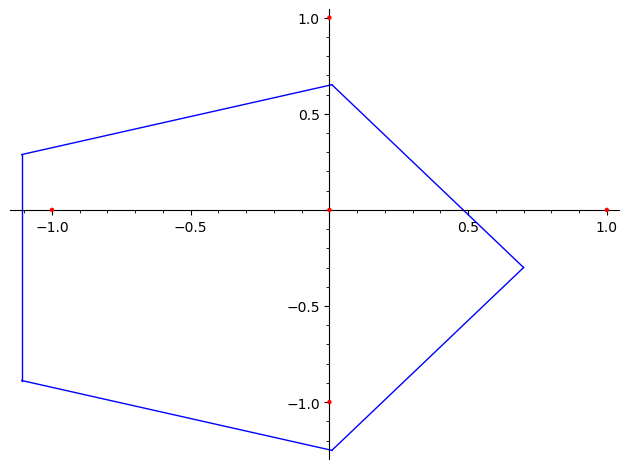

In [10]:
# Note we have to perturb the equator slightly to avoid the branch points with modulus 1. 
ng = 5
vertices = [exp(2*k*S._CC(pi*sqrt(-1))/ng) - 0.3*(1+I) for k in range(ng)]
downstairs_edges = [(i, i+1) for i in range(ng-1)] + [(0, ng-1)]

wvalues = [S.w_values(zi) for zi in vertices]

###
# UPSTARIS_EDGES
###
L = {}
edgeset = []
n = len(S._wvalues[0])
# Lifts each edge individually.
for e in downstairs_edges:
    i0, i1 = e
    d_edge = (vertices[i0], vertices[i1])
    # Epsilon for checking w-value later.
    epsilon = min([abs(wvalues[i1][i] - wvalues[i1][n-j-1]) 
                   for i in range(n) for j in range(n-i-1)])/3
    # Homotopy continuation along e.
    L[e] = S.homotopy_continuation(d_edge)
    homotopycont = L[e][-1][1]
    for i in range(len(homotopycont)):
        # Checks over the w-values of the next point to check which it is.
        for j in range(len(wvalues[i1])):
            if abs(homotopycont[i] - wvalues[i1][j]) < epsilon:
                # Once it finds the appropriate w-value, adds the edge.
                edgeset = edgeset + [[(i0, i), (i1, j)]]
                continue
upstairs_edges = edgeset

###
# EDGE_PERMUTATIONS
###

def edge_permutation(edge):
    if edge in downstairs_edges:
        # find all upstairs edges that are lifts of the given
        # downstairs edge and store the corresponding indices at
        # start and end that label the branches upstairs.
        L = [(j0, j1) for ((i0, j0), (i1, j1)) in upstairs_edges
             if edge == (i0, i1)]
        # we should be finding exactly "degree" of these
        assert len(L) == S.degree
        # and as a corollary of how we construct them, the indices
        # at the start should be in order
        assert all(a == b[0] for a, b in enumerate(L))
        return S._Sn([j1 for j0, j1 in L])
    raise ValueError('edge not in polygon')
    
D = {e: edge_permutation(e) for e in downstairs_edges}
for (a, b), p in list(D.items()):
    D[(b, a)] = p**(-1)
edge_permutations = D

###
# FINAL RESULT
###

equator_monodromy = prod(edge_permutations[(i, (i+1)%ng)] 
                         for i in range(ng))
print("Monodromy around equator:", equator_monodromy)

point2d([bi for bi in S.branch_locus if bi.abs()<=1], 
        color='red', zorder=200) + sum([line((vertices[i0], vertices[i1])) 
                            for i0, i1 in downstairs_edges])